<a href="https://colab.research.google.com/github/SaloWi/cas_mod4/blob/main/M6_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## M6 Project

#### Mayra and Salomé

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_percentage_error

import torch.nn as nn
import torch.optim as optim
import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pickle


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [ ]:

# Load dataset
data = pd.read_csv('insurance.csv')  # Replace with your dataset's name
# Display the first few rows
print(data.head())
# Check for missing values
print(data.isnull().sum())
# Basic statistics
print(data.describe())
# Display data types
print(data.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000  

In [ ]:
# Encode categorical variables
categorical_columns = ['sex', 'smoker', 'region']
encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])
# Features and target variable
X = data.drop(columns=['charges'])  # Features
y = data['charges']                 # Target (insurance cost)
# Normalize numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE and MAE for regression


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Adjust epochs as needed
    batch_size=32
)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 321400960.0000 - mae: 13382.2568 - val_loss: 323379168.0000 - val_mae: 12966.7139
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 345507104.0000 - mae: 14021.1875 - val_loss: 323278752.0000 - val_mae: 12963.3984
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 310054240.0000 - mae: 13065.6973 - val_loss: 323059168.0000 - val_mae: 12956.5898
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 330775776.0000 - mae: 13345.2041 - val_loss: 322636192.0000 - val_mae: 12944.1895
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 313260864.0000 - mae: 13122.4658 - val_loss: 321906880.0000 - val_mae: 12923.7227
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 321690560.0000 - mae: 13308.4033 - val_loss: 320698048.0000 - val_mae: 12891.2432
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 320440832.0000 - mae: 13176.2861 - val_loss: 318926080.0000 - val_mae: 12844.9434
Epoch 8/50
34/34 ━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29530888.0000 - mae: 3898.3503 
Test Loss (MSE): 32480318.0
Test Mean Absolute Error (MAE): 4035.398681640625
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


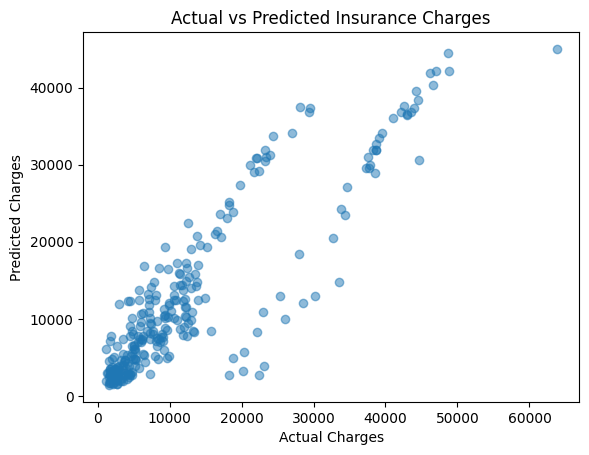

In [ ]:
# Evaluate on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

# Make predictions
y_pred = model.predict(X_test)
# Compare predictions vs actual values
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Insurance Charges")
plt.show()
